# SOM for geospatial analysis

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
from shapely.geometry import Point

In [2]:
import pysom
import somoclu

## 0. Load and pre-process datasets

### 0.1 Countries shapefile

In [3]:
countries = gpd.read_file('../../data/naturalearth/10m_cultural/10m_cultural/ne_10m_admin_0_countries.shp')

### 0.2 ERSST sea surface temperature data

In [4]:
sst = xr.load_dataarray('../../../projects/AgRisk/climatedata/ERSSTv5_1900_2019_anom_20Aug2020.nc')

### 0.3 IBTrACS typhoon track data

Load a Western Pacific subset.

In [5]:
ibtracs_WP = gpd.read_file('/Users/mutahar/Documents/projects/AgRisk/climatedata/IBTrACS.WP.list.v04r00.lines.shp')

Pre-processing: 
- populate combined pressure field, first WMO, then Tokyo, then CMA.
- dissolve by storm ID, while retaining SEASON and (minimum) central pressure over the track, to get a single geometry per storm:

In [6]:
ibtracs_WP['PRES'] = ibtracs_WP['WMO_PRES'].fillna(ibtracs_WP['TOK_PRES']
                                                  ).fillna(ibtracs_WP['CMA_PRES']
                                                          ).fillna(ibtracs_WP['HKO_PRES']
                                                                  ).fillna(ibtracs_WP['BOM_PRES']
                                                                          ).fillna(ibtracs_WP['NEW_PRES']
                                                                                  ).fillna(ibtracs_WP['REU_PRES']
                                                                                          ).fillna(ibtracs_WP['NAD_PRES']
                                                                                                  ).fillna(ibtracs_WP['WEL_PRES'])

In [7]:
ibtracs_WP_post1950 = ibtracs_WP.loc[ibtracs_WP['SEASON']>=1950,['SID','SEASON','PRES','geometry']].dissolve('SID', aggfunc='min')
ibtracs_WP_post1950.head(2)

,geometry,SEASON,PRES
SID,,,
1950101N16170,"MULTILINESTRING ((170.00000 16.00000, 169.3601...",1950,984.0
1950126N09151,"MULTILINESTRING ((150.80005 8.60000, 150.45496...",1950,930.0


Buffer geometry by 0.25 degrees to get some thickness to smooth rasterisation:

In [8]:
ibtracs_WP_post1950['geometry'] = ibtracs_WP_post1950['geometry'].buffer(0.25)

/var/folders/8v/b9plfgq912j9smlpdx8jsj9h0000gn/T/ipykernel_8131/1423090264.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ibtracs_WP_post1950['geometry'] = ibtracs_WP_post1950['geometry'].buffer(0.25)


Make 0.5 degree grid over Western Pacific, in order to rasterise TC tracks:

In [9]:
lats, lons = np.meshgrid(np.arange(0, 62, 0.5), np.arange(100, 180, 0.5))

In [10]:
gdf = gpd.GeoDataFrame({'lat': lats.ravel(), 
                        'lon': lons.ravel(), 
                        'geometry': [Point(lon, lat).buffer(0.25, cap_style=3) for lat, lon in zip(lats.ravel(), lons.ravel())]}, 
                       crs='epsg:4326')

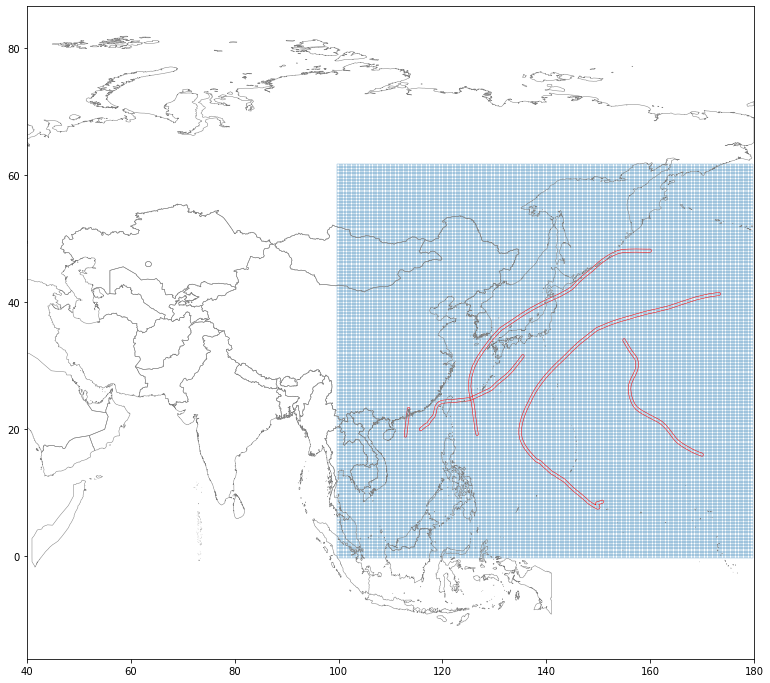

In [11]:
ax = gdf.boundary.plot(figsize=(24,12), lw=0.25);
ibtracs_WP_post1950[:5].boundary.plot(ax=ax, lw=0.5, color='r');
countries.cx[slice(50,180), slice(0,60)].boundary.plot(ax=ax, color='0.5', lw=0.5)
ax.set_xlim([40, 180]);

Rasterise tracks by doing spatial join and add "one hot" column:

In [12]:
ibtracs_WP_grid = gpd.sjoin(ibtracs_WP_post1950, gdf)
ibtracs_WP_grid['flag'] = 1

## 2. Processing

### 2.1 SST data

Extract August regional SSTs.

In [13]:
sstWP_August = sst.sel(month=8, lat=slice(-50,50), lon=slice(40, 180))
X_sstWP_August = sstWP_August.to_series().unstack(['lat','lon']).fillna(0)

In [14]:
n_cols, n_rows = 3, 3

som_sst = pysom.SOM(n_rows, n_cols, neighbourhood='linear')
som_sst.fit(X_sstWP_August.values, initial='pca', n_epochs=50)

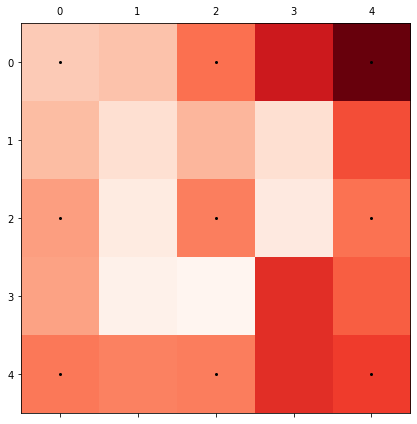

In [15]:
som_sst.umatrix()

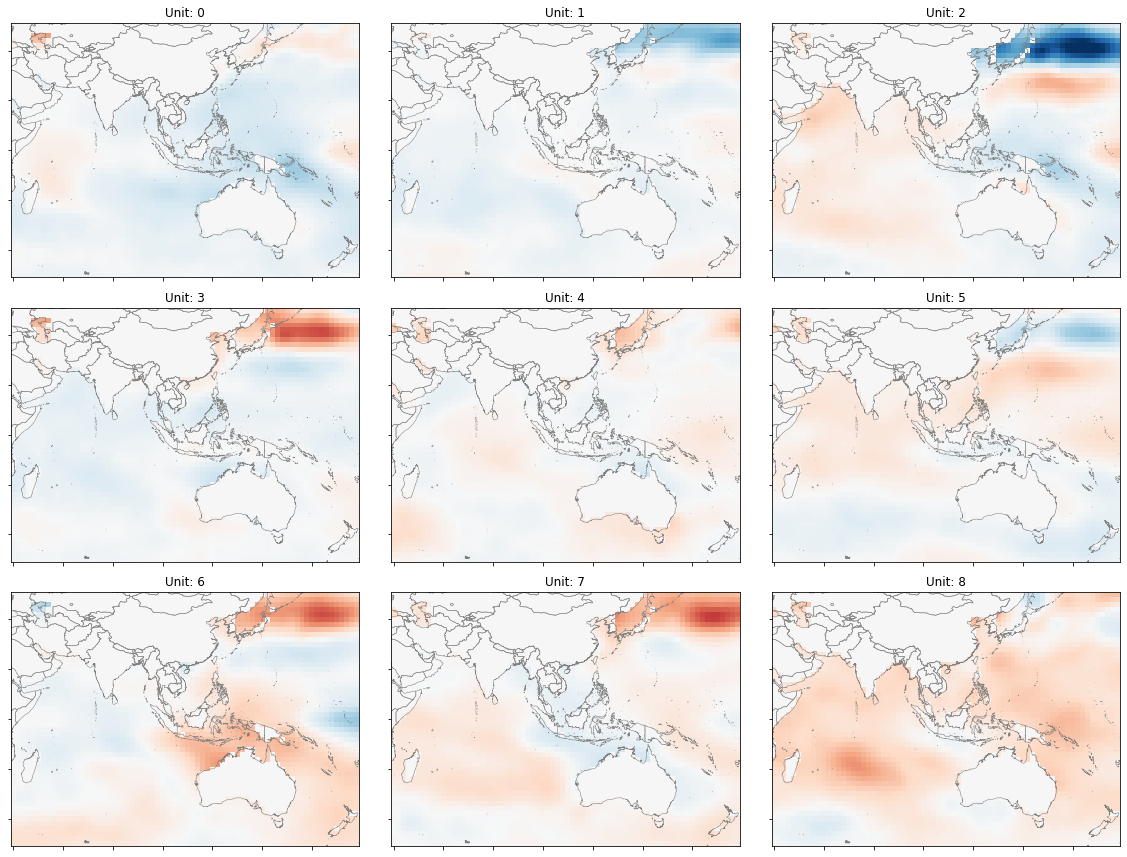

In [16]:
som_da = xr.DataArray(som_sst.wts.reshape((n_rows, n_cols, sstWP_August.lat.size, sstWP_August.lon.size)), 
                      dims=['i','j','lat','lon'], 
                      coords={'lat': sstWP_August.lat, 'lon': sstWP_August.lon})

fig = plt.figure(figsize=(16,12))
k = 0 
for i in range(n_cols):
    for j in range(n_rows):
        ax = plt.subplot2grid((n_rows, n_cols), (i, j))
        som_da.sel(i=i, j=j).plot(ax=ax, cmap='RdBu_r', vmin=-2, vmax=2, add_colorbar=False)
        ax.set_xticklabels([]); ax.set_yticklabels([]);
        ax.set_xlabel(''); ax.set_ylabel('');
        ax.set_title(f'Unit: {k}')
        plt.grid(False)
        countries.boundary.plot(ax=ax, color='0.5', lw=0.5)
        k += 1
plt.tight_layout()

Plot annual time series of BMUS:

In [17]:
years = sstWP_August.year.values
ts_bmu = pd.Series(som_sst.bmus, index=years)
ts_bmu.value_counts()

6    18
1    17
3    15
2    14
5    14
7    12
0    11
8    10
4     9
dtype: int64

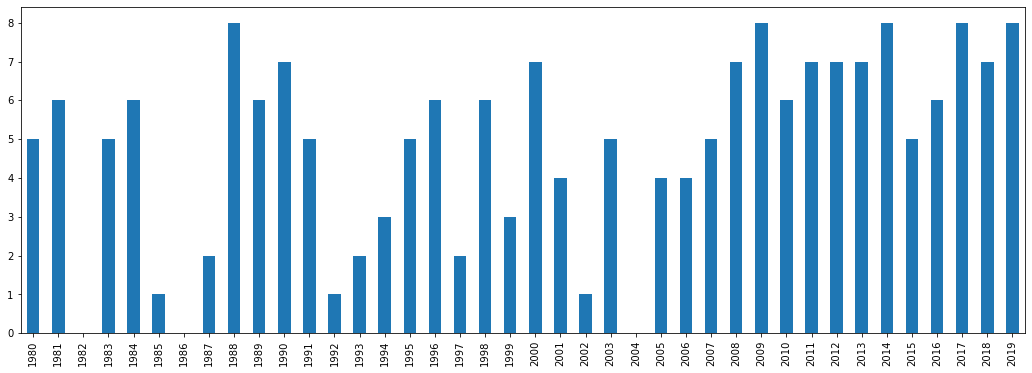

In [18]:
ts_bmu.loc[slice(1980, 2021)].plot.bar(figsize=(18,6));

Plot some El Nino years:

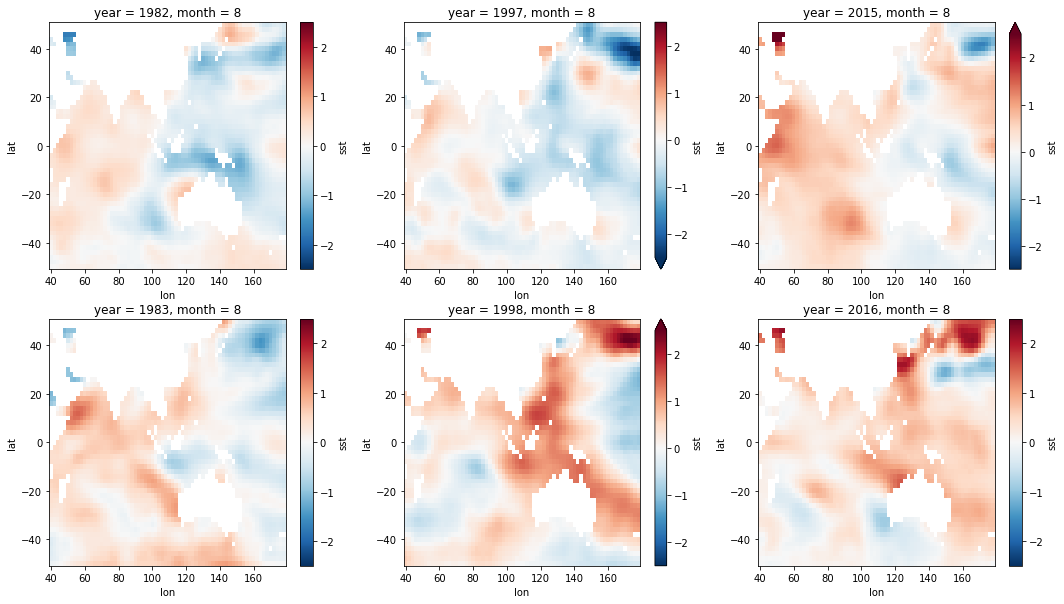

In [19]:
fig, axes = plt.subplots(2,3, figsize=(18,10))
sstWP_August.sel(year=1982).plot(ax=axes[0][0], vmin=-2.5, vmax=2.5, cmap='RdBu_r')
sstWP_August.sel(year=1983).plot(ax=axes[1][0], vmin=-2.5, vmax=2.5, cmap='RdBu_r')
sstWP_August.sel(year=1997).plot(ax=axes[0][1], vmin=-2.5, vmax=2.5, cmap='RdBu_r')
sstWP_August.sel(year=1998).plot(ax=axes[1][1], vmin=-2.5, vmax=2.5, cmap='RdBu_r')
sstWP_August.sel(year=2015).plot(ax=axes[0][2], vmin=-2.5, vmax=2.5, cmap='RdBu_r')
sstWP_August.sel(year=2016).plot(ax=axes[1][2], vmin=-2.5, vmax=2.5, cmap='RdBu_r');

### 2.2 Cyclone tracks

In [20]:
min_PRES = 980

X_cyc = ibtracs_WP_grid[ibtracs_WP_grid['PRES']<=min_PRES].set_index(['lat','lon'], append=True)['flag'].unstack(['lat','lon'], fill_value=0)
X_cyc

lat            29.0  29.5  30.0  30.5  31.0  31.5  28.5  22.0              \
lon           157.5 157.5 157.5 157.5 157.5 157.5 157.5 160.5 159.5 161.0   
SID                                                                         
1950126N09151     0     0     0     0     0     0     0     0     0     0   
1950174N19127     0     0     0     0     0     0     0     0     0     0   
1950196N21144     0     0     0     0     0     0     0     0     0     0   
1950221N19124     0     0     0     0     0     0     0     0     0     0   
1950222N22161     0     0     0     0     0     0     0     1     1     1   
...             ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
2020277N21141     0     0     0     0     0     0     0     0     0     0   
2020291N06141     0     0     0     0     0     0     0     0     0     0   
2020296N09137     0     0     0     0     0     0     0     0     0     0   
2020299N11144     0     0     0     0     0     0     0     0     0     0   
2020313N08135     0     0     0     0     0     0     0     0     0     0   

lat            ...  47.5              48.0              48.5        49.0  50.0  
lon            ... 124.0 124.5 125.0 124.0 125.0 124.5 124.0 124.5 124.0 124.0  
SID            ...                                                              
1950126N09151  ...     0     0     0     0     0     0     0     0     0     0  
1950174N19127  ...     0     0     0     0     0     0     0     0     0     0  
1950196N21144  ...     0     0     0     0     0     0     0     0     0     0  
1950221N19124  ...     0     0     0     0     0     0     0     0     0     0  
1950222N22161  ...     0     0     0     0     0     0     0     0     0     0  
...            ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
2020277N21141  ...     0     0     0     0     0     0     0     0     0     0  
2020291N06141  ...     0     0     0     0     0     0     0     0     0     0  
2020296N09137  ...     0     0     0     0     0     0     0     0     0     0  
2020299N11144  ...     0     0     0     0     0     0     0     0     0     0  
2020313N08135  ...     0     0     0     0     0     0     0     0     0     0  

[1227 rows x 15197 columns]

##### Identify Maemi's `SID` and visualise

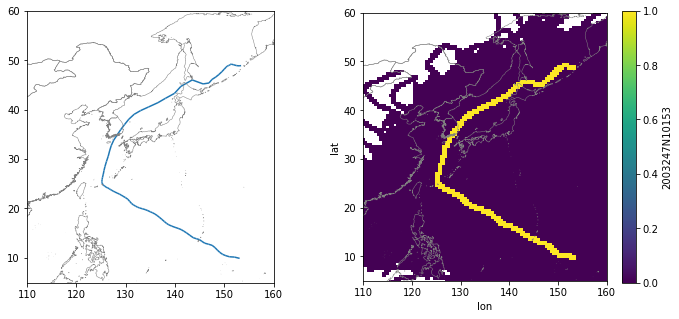

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
ibtracs_WP[ibtracs_WP['NAME']=='MAEMI'].plot(ax=ax1)
X_cyc.loc['2003247N10153'].to_xarray().sortby(['lat','lon']).plot(ax=ax2);
countries.boundary.plot(ax=ax1, color='0.5', lw=0.5)
countries.boundary.plot(ax=ax2, color='0.5', lw=0.5)
ax1.set_xlim((110,160)); ax1.set_ylim((5,60));
ax2.set_xlim((110,160)); ax2.set_ylim((5,60));

In [22]:
n_cols, n_rows = 3, 3
som_cyc = pysom.SOM(n_rows, n_cols, neighbourhood='gaussian')

In [23]:
%%time
som_cyc.fit(X_cyc.values, initial='pca', n_epochs=10)

CPU times: user 33min 7s, sys: 1min 5s, total: 34min 12s
Wall time: 5min 35s


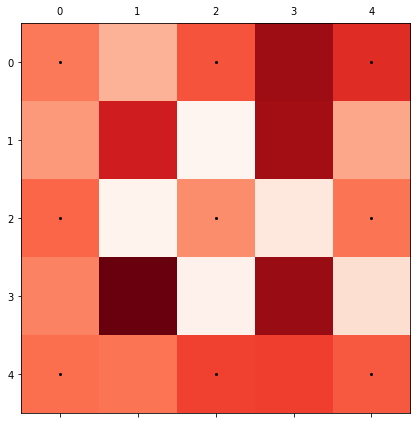

In [24]:
som_cyc.umatrix()

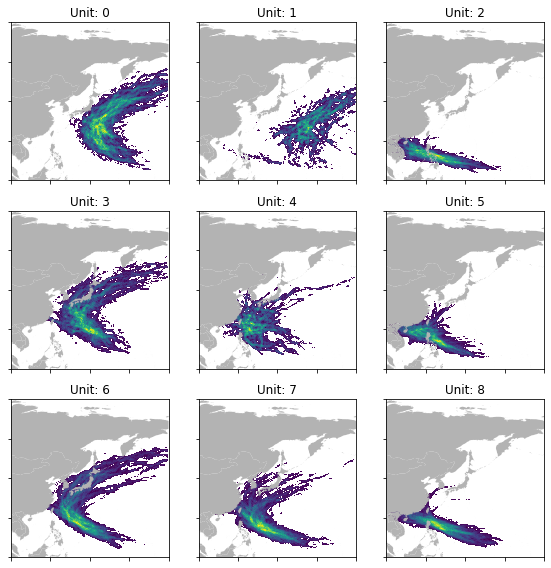

In [25]:
fig = plt.figure(figsize=(8,8))
thresh = 0.025
k = 0 
for i in range(n_rows):
    for j in range(n_cols):
        ax = plt.subplot2grid((n_rows, n_cols), (i, j))
        wts_filt = np.where(som_cyc.wts[k]>thresh, som_cyc.wts[k], np.nan)
        pd.Series(wts_filt, index=X_cyc.columns).to_xarray().sortby(['lat','lon']).plot(ax=ax, cmap='viridis', add_colorbar=False)
        ax.set_xticklabels([]); ax.set_yticklabels([]);
        ax.set_xlabel(''); ax.set_ylabel('');
        ax.set_title(f'Unit: {k}')
        countries.plot(ax=ax, color='0.7', lw=1);
        ax.set_xlim([100, 180])
        ax.set_ylim([0, 80])
        plt.grid(False)
        k += 1
plt.tight_layout()

In [26]:
# Classify
c = som_cyc.predict(X_cyc.values)
cc = pd.DataFrame(c, index=X_cyc.index, columns=['class']).reset_index()
ibtracs_WP_class = ibtracs_WP_post1950.merge(cc, on='SID')

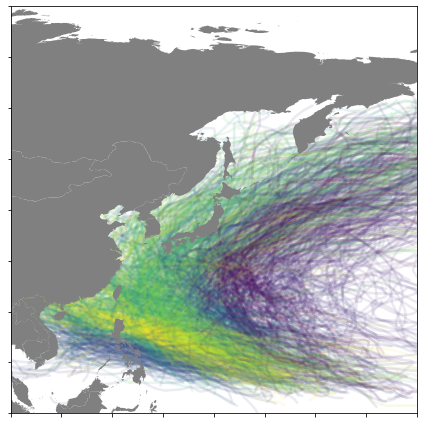

In [27]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

ibtracs_WP_class.plot(column='class', ax=ax, lw=0.5, alpha=0.1, cmap='viridis')
ax.set_xticklabels([]); ax.set_yticklabels([]);
ax.set_xlabel(''); ax.set_ylabel('');
countries.plot(ax=ax, color='0.5', lw=1);
ax.set_xlim([100, 180])
ax.set_ylim([0, 80])
plt.grid(False)
plt.tight_layout();

In [28]:
class_by_season = ibtracs_WP_class.groupby(['SEASON','class'])['PRES'].count().unstack('class').fillna(0)
class_by_season_sum = class_by_season.sum(axis=1)
class_by_season_norm = class_by_season.div(class_by_season_sum, axis=0)
class_by_season

class,0,1,2,3,4,5,6,7,8
SEASON,,,,,,,,,
1950,1.0,3.0,0.0,3.0,0.0,0.0,5.0,1.0,1.0
1951,1.0,5.0,2.0,0.0,0.0,0.0,2.0,2.0,4.0
1952,1.0,1.0,4.0,0.0,1.0,4.0,3.0,2.0,1.0
1953,4.0,2.0,1.0,1.0,1.0,3.0,2.0,3.0,1.0
1954,1.0,1.0,2.0,4.0,0.0,1.0,0.0,1.0,4.0
...,...,...,...,...,...,...,...,...,...
2016,3.0,1.0,1.0,2.0,1.0,5.0,2.0,3.0,1.0
2017,1.0,3.0,2.0,0.0,1.0,1.0,2.0,1.0,1.0
2018,1.0,2.0,0.0,4.0,0.0,0.0,4.0,2.0,2.0


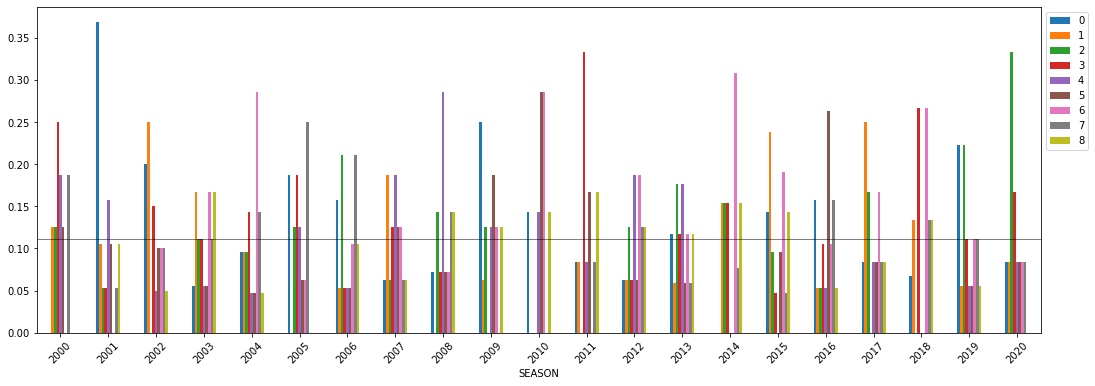

In [29]:
ax = class_by_season_norm.loc[range(2000,2021)].plot.bar(figsize=(18,6), stacked=False, rot=45)
ax.legend(bbox_to_anchor=(1,1))
ax.axhline(1/(n_cols*n_rows), lw=0.5, color='0');

### Compare with Somoclu

In [30]:
som_somoclu = somoclu.Somoclu(n_cols, n_rows, compactsupport=False)

In [31]:
%%time
som_somoclu.train(X_cyc.values, epochs=50)

CPU times: user 17 s, sys: 527 ms, total: 17.5 s
Wall time: 2.51 s


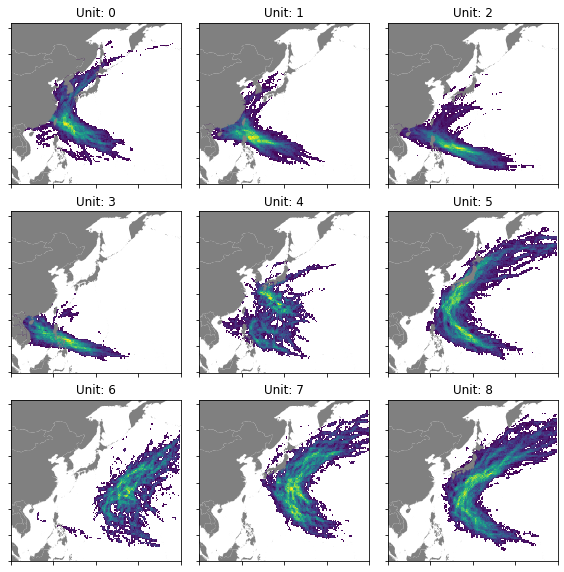

In [32]:
fig = plt.figure(figsize=(8,8))
thresh = 0.025
k = 0
for i in range(n_rows):
    for j in range(n_cols):
        ax = plt.subplot2grid((n_rows, n_cols), (i, j))
        codebook_filt = np.where(som_somoclu.codebook[i][j]>thresh, som_somoclu.codebook[i][j], np.nan)

        pd.Series(codebook_filt, index=X_cyc.columns).to_xarray().sortby(['lat','lon']).plot(ax=ax, cmap='viridis', add_colorbar=False)
        ax.set_xticklabels([]); ax.set_yticklabels([]);
        ax.set_xlabel(''); ax.set_ylabel('');
        ax.set_title(f'Unit: {k}')
        countries.cx[slice(100,180), slice(0,60)].plot(ax=ax, color='0.5', lw=0.5);
        ax.set_xlim([100, 180]);
        plt.grid(False)
        k += 1
plt.tight_layout()